In [2]:
import argparse as ap
from collections import namedtuple
import csv
from enum import Enum
import jax as jax
import jax.numpy as np
import math as math
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import pickle as pl
import random as rand
import time as time

In [35]:
input_mol = "isobutane"
energyHistory = pd.read_csv(input_mol + '_energyHistory.csv')
bondHistory = pd.read_csv(input_mol + '_bondLengthHistory.csv')
dataLen = energyHistory["time"].count()
dataLen

1001

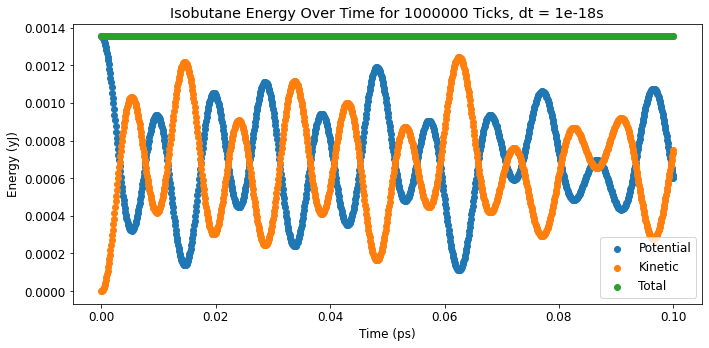

<Figure size 432x288 with 0 Axes>

In [33]:
def draw_energy(energyHistory, input_mol, input_ticks, dt, time_unit, q_start = 0, q_end = 4, out_file = None, title_suffix = ""):
    dataLen = energyHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : max(12, dataLen / 300 * (q_end - q_start) / 4)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (max(10, dataLen / 100 * (q_end - q_start) / 4), 5))
    plt.rc('font', **font)
    plt.scatter(energyHistory["time"][rng], energyHistory["potentialE"][rng], label = 'Potential')
    plt.scatter(energyHistory["time"][rng], energyHistory["kineticE"][rng], label = 'Kinetic')
    plt.scatter(energyHistory["time"][rng], energyHistory["potentialE"][rng] + energyHistory["kineticE"][rng], label = 'Total')

    plt.title(input_mol.capitalize() + " Energy Over Time for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (yJ)')
    plt.legend(prop = {'size' : max(12, dataLen / 400 * (q_end - q_start) / 4)})
    plt.tight_layout()
    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

draw_energy(energyHistory, input_mol, 1_000_000, 1e-18, 1e12, 0, 4)

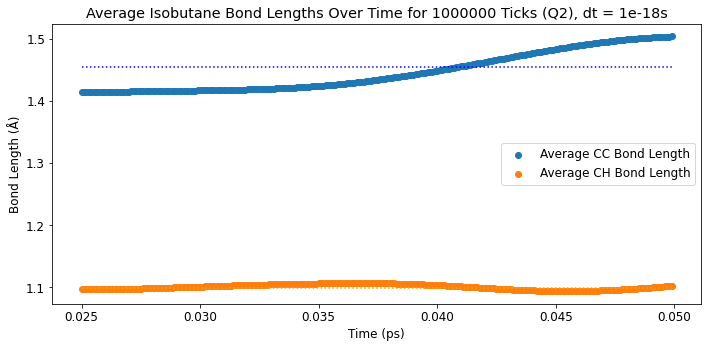

<Figure size 432x288 with 0 Axes>

In [39]:
def draw_bond(bondHistory, input_mol, input_ticks, dt, time_unit, q_start = 0, q_end = 4, out_file = None, title_suffix = ""):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : max(12, dataLen / 750 * (q_end - q_start) / 4)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (max(10, dataLen / 400 * (q_end - q_start) / 4), 5))
    plt.rc('font', **font)
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.455, 1.455], color = 'blue', linestyle = ':')
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.099, 1.099], color = 'orange', linestyle = ':')

    plt.scatter(bondHistory["time"][rng], bondHistory["CC_Bonds"][rng], label = 'Average CC Bond Length')
    plt.scatter(bondHistory["time"][rng], bondHistory["CH_Bonds"][rng], label = 'Average CH Bond Length')

    plt.title("Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    plt.xlabel('Time (ps)')
    plt.ylabel('Bond Length (Å)')
    plt.legend(prop = {'size' : max(12, dataLen / 1000 * (q_end - q_start) / 4)})
    plt.tight_layout()
    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

draw_bond(bondHistory, input_mol, 1_000_000, 1e-18, 1e12, 0, 4)

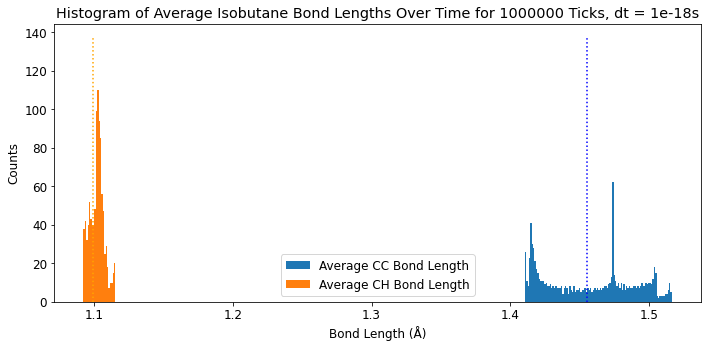

<Figure size 432x288 with 0 Axes>

In [108]:
def draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, time_unit, binWidth, out_file = None):
    font = {'family' : 'DejaVu Sans',
        'size' : 12}

    plt.figure(figsize = (10, 5))
    plt.rc('font', **font)

    cc_bins = np.arange(min(bondHistory["CC_Bonds"]), max(bondHistory["CC_Bonds"]) + binWidth, binWidth)
    cc_hist = plt.hist(bondHistory["CC_Bonds"], bins = cc_bins, label = 'Average CC Bond Length')

    ch_bins = np.arange(min(bondHistory["CH_Bonds"]), max(bondHistory["CH_Bonds"]) + binWidth, binWidth)
    ch_hist = plt.hist(bondHistory["CH_Bonds"], bins = ch_bins, label = 'Average CH Bond Length')

    maxY = max(np.max(cc_hist[0]), np.max(ch_hist[0]))

    plt.plot([1.455, 1.455], [0, maxY * 1.25], color = 'blue', linestyle = ':')
    plt.plot([1.099, 1.099], [0, maxY * 1.25], color = 'orange', linestyle = ':')

    plt.title("Histogram of Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks, dt = " + str(dt) + "s")
    plt.xlabel('Bond Length (Å)')
    plt.ylabel('Counts')
    plt.legend(prop = {'size' : 12})
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

draw_bond_histogram(bondHistory, input_mol, 1_000_000, 1e-18, 1e12, 0.001)

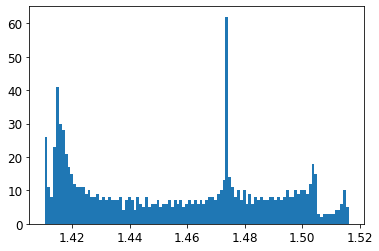

In [98]:
import scipy as sp

binWidth = 0.001
bins = np.arange(min(bondHistory["CC_Bonds"]), max(bondHistory["CC_Bonds"]) + binWidth, binWidth)
stats = sp.stats.binned_statistic(bondHistory["CC_Bonds"], values = bondHistory["CC_Bonds"], bins = bins, statistic='mean')
buckets = plt.hist(bondHistory["CC_Bonds"], label = 'Average CC Bond Length',  bins = bins)

In [99]:
buckets[0][np.argmax(buckets[0])]

62.0

In [95]:
onp.histogram(bondHistory["CC_Bonds"], 100)

(array([27, 11,  9, 33, 37, 32, 25, 22, 16, 15, 12, 12, 11,  9, 10, 10,  9,
         8,  8,  9,  7,  8,  8,  7,  7,  6,  7,  8,  7,  6,  6,  8,  7,  4,
         8,  6,  6,  8,  5,  6,  6,  7,  7,  6,  7,  5,  9,  5,  6,  8,  6,
         7,  7,  8,  7,  9,  7, 10, 10, 14, 64, 13, 10, 11,  8,  9,  8,  8,
         8,  8,  8,  7,  8,  8,  8,  8,  8,  8,  8,  9,  8,  9, 10,  9, 11,
        11,  9, 11, 15, 23,  3,  2,  3,  3,  4,  3,  4,  5,  5, 15]),
 array([1.41030468, 1.41135594, 1.4124072 , 1.41345846, 1.41450972,
        1.41556098, 1.41661224, 1.4176635 , 1.41871475, 1.41976601,
        1.42081727, 1.42186853, 1.42291979, 1.42397105, 1.42502231,
        1.42607357, 1.42712483, 1.42817609, 1.42922735, 1.43027861,
        1.43132986, 1.43238112, 1.43343238, 1.43448364, 1.4355349 ,
        1.43658616, 1.43763742, 1.43868868, 1.43973994, 1.4407912 ,
        1.44184246, 1.44289371, 1.44394497, 1.44499623, 1.44604749,
        1.44709875, 1.44815001, 1.44920127, 1.45025253, 1.45130379,
      